<a href="https://colab.research.google.com/github/christophermoverton/scientific-multilabel-classification/blob/main/scientific_multilabel_classification_comparative_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Introduction

Topic modeling and multi-label classification of research articles present meaningful challenges in modern scientific information retrieval. As the volume of published papers continues to grow, identifying distinct disciplinary labels becomes increasingly difficult—particularly when fields are highly nuanced and certain categories exhibit label sparsity.

This project leverages a recent Kaggle dataset spanning both broad and data-sparse disciplines to explore these classification challenges. The dataset includes six topic labels: Computer Science, Physics, Mathematics, Statistics, Quantitative Biology, and Quantitative Finance.

We begin with exploratory data analysis to examine class imbalance, vocabulary overlap, and interdisciplinary structure. An unsupervised Latent Dirichlet Allocation (LDA) model is used to uncover latent semantic clusters and assess how well topic modeling aligns with labeled categories.

We then implement a supervised One-vs-Rest Logistic Regression model to establish a classical machine learning baseline. Finally, we fine-tune SciBERT, a domain-specific transformer model trained on scientific literature, to evaluate the performance gains from contextual deep learning representations.

Through structured comparison across unsupervised and supervised approaches, this study investigates the impact of class imbalance, model architecture, and probability calibration on multi-label scientific document classification.

### 1. Mount Google Drive

Run the following cell to mount your Google Drive to the Colab environment. You will be prompted to authenticate your Google account.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Read data from Google Drive

Once your Drive is mounted, you can access files. For example, to read a CSV file named `my_data.csv` located in the root of your Google Drive, you can use the following code. Make sure to replace `my_data.csv` with the actual path to your file.

In [55]:
import pandas as pd

# Example: reading a CSV file from Google Drive
# Replace 'my_data.csv' with the actual path to your file in Google Drive
file_path = '/content/drive/MyDrive/archive (2)/train.csv'
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}. First 5 rows:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path and make sure the file exists in your Google Drive.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded data from /content/drive/MyDrive/archive (2)/train.csv. First 5 rows:


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [56]:
df["text"] = df["TITLE"] + df["ABSTRACT"]

In [57]:
pip install spacy

In [58]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Titles and abstracts were combined into a single text field and cleaned using spaCy. Citation markers (e.g., [12]) were removed, and tokens were filtered to exclude stopwords, punctuation, whitespace, URLs, emails, and numeric values. Remaining tokens were lemmatized and lowercased. Processing was performed in batches using nlp.pipe() for efficiency. The resulting cleaned_text column was used for topic modeling and classification.

In [59]:
import pandas as pd
import re
import spacy

#Load spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

df["text"] = df["TITLE"].fillna("") + df["ABSTRACT"].fillna("")


df["text"] = df["text"].str.replace(r"\[[0-9]+\]", "", regex=True)

def clean_text_spacy(doc):
    tokens = []

    for token in doc:
        if (
            not token.is_stop
            and not token.is_punct
            and not token.is_space
            and not token.like_url
            and not token.like_email
            and not token.like_num
            and len(token) > 2
        ):
            tokens.append(token.lemma_.lower())

    return " ".join(tokens)

cleaned = []

for doc in nlp.pipe(df["text"], batch_size=50):
    cleaned.append(clean_text_spacy(doc))

df["cleaned_text"] = cleaned

### EDA for Label Distribution

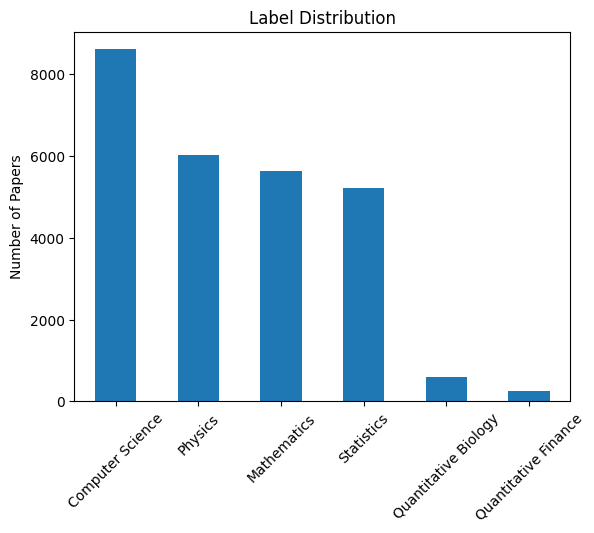

In [60]:
import matplotlib.pyplot as plt

target_cols = [
    "Computer Science",
    "Physics",
    "Mathematics",
    "Statistics",
    "Quantitative Biology",
    "Quantitative Finance"
]

label_counts = df[target_cols].sum().sort_values(ascending=False)

plt.figure()
label_counts.plot(kind="bar")
plt.title("Label Distribution")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45)
plt.show()

Label Distribution results show dominance with article topics like Computer Science and subsequently Physics.  We should make note of this in relationship to LDA topic model findings as especially correlated to these dominant labels.  As we shall see later Physics and Mathematics have particularly strong correlative signals to single topic classification or dual topic classification.  Computer Science as a topic is, however, slightly weaker for dual topic correlation.

In [61]:
df["label_count"] = df[target_cols].sum(axis=1)
df["label_count"].describe()

,label_count
count,20972.000000
mean,1.252479
std,0.461173
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


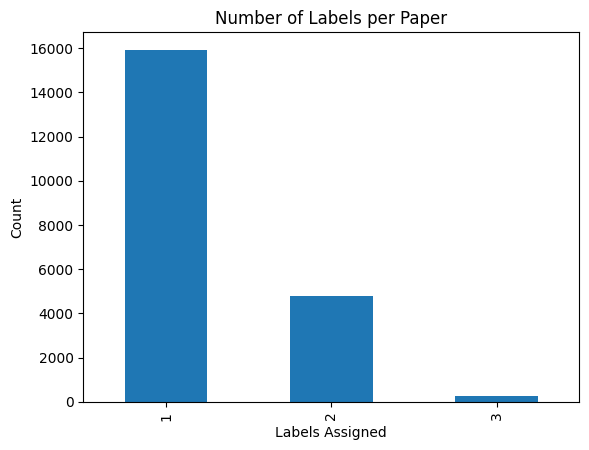

In [62]:
plt.figure()
df["label_count"].value_counts().sort_index().plot(kind="bar")
plt.title("Number of Labels per Paper")
plt.xlabel("Labels Assigned")
plt.ylabel("Count")
plt.show()

Because disciplines such as Mathematics and its subfields—like Statistics—or areas such as Discrete Mathematics often share vocabulary with Computer Science, disciplinary boundaries in text are not always cleanly separable. Although dual-labeled articles constitute a minority within the dataset, they are not negligible. This overlap suggests that shared or mixed vocabularies may complicate topic segmentation and classification, particularly when models rely heavily on word co-occurrence patterns.

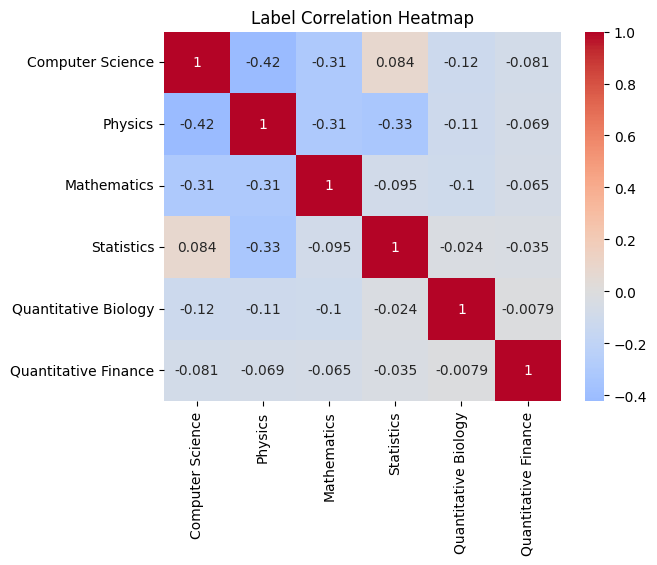

In [63]:
import seaborn as sns
import numpy as np

corr = df[target_cols].corr()

plt.figure()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Label Correlation Heatmap")
plt.show()

Label correlation analysis revealed predominantly negative relationships among major disciplines, indicating mutual exclusivity in topic assignment. Minority fields exhibited near-zero correlations, suggesting that classification challenges stem primarily from data sparsity rather than label entanglement. This structural property supports the use of independent multi-label classifiers and explains the effectiveness of both classical and transformer-based approaches.

In [64]:
df["cleaned_text"].head()

,cleaned_text
0,reconstruct subject specific effect maps predi...
1,rotation invariance neural network rotation in...
2,spherical polyharmonic poisson kernel polyharm...
3,finite element approximation stochastic maxwel...
4,comparative study discrete wavelet transforms ...


In [65]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_df=.9,
    min_df=10,
    stop_words="english"
)

X = vectorizer.fit_transform(df["cleaned_text"])
#

In [66]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=6,
    random_state=42,
    learning_method="batch"
)

lda.fit(X)

LatentDirichletAllocation(n_components=6, random_state=42)

In [67]:
def display_topics(model, feature_names, n_top_words=10):
  for idx, topic in enumerate(model.components_):
    print(f"\nTopic {idx}:")
    print(
        " ".join(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        )
    )

display_topics(lda, vectorizer.get_feature_names_out())


Topic 0:
equation function space result group graph prove problem solution set

Topic 1:
state phase spin quantum field magnetic temperature energy transition model

Topic 2:
algorithm method problem model propose base datum approach time network

Topic 3:
network model datum base learning approach propose method image task

Topic 4:
mass star high galaxy field model energy wave particle result

Topic 5:
model distribution process study time analysis datum result effect dynamic


In [68]:
topic_distribution = lda.transform(X)
df["lda_topic"] = topic_distribution.argmax(axis=1)

In [69]:
pd.crosstab(df["lda_topic"], df["Computer Science"])

Computer Science,0,1
lda_topic,,
0,3940,820
1,2202,40
2,1903,3066
3,890,4221
4,2272,55
5,1171,392


In [70]:
ct = pd.crosstab(df["lda_topic"], df["Computer Science"])

ct["cs_pct"] = ct[1] / (ct[0]+ct[1])
ct

Computer Science,0,1,cs_pct
lda_topic,,,
0,3940,820,0.172269
1,2202,40,0.017841
2,1903,3066,0.617026
3,890,4221,0.825866
4,2272,55,0.023636
5,1171,392,0.250800


LDA identified coherent semantic clusters, with certain topics exhibiting high purity for Computer Science. However, disciplinary boundaries were diffuse, reflecting interdisciplinary vocabulary overlap.

Building Topic Label Tables

In [71]:
target_cols = [
    "Computer Science",
    "Physics",
    "Mathematics",
    "Statistics",
    "Quantitative Biology",
    "Quantitative Finance"
]

topic_label_tables = {}

for label in target_cols:
    ct = pd.crosstab(df["lda_topic"], df[label])
    ct["pct_positive"] = ct[1] / (ct[0] + ct[1])
    topic_label_tables[label] = ct


Summary Table

In [72]:
import numpy as np

summary = pd.DataFrame(index=sorted(df["lda_topic"].unique()), columns=target_cols)

for label in target_cols:
  ct = pd.crosstab(df["lda_topic"], df[label])
  pct = ct[1]/(ct[0] + ct[1])
  summary[label] = pct

summary = summary.astype(float)
summary

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0.172269,0.099160,0.822059,0.051050,0.003151,0.002941
1,0.017841,0.942908,0.024086,0.005352,0.037467,0.000446
2,0.617026,0.070235,0.230831,0.550010,0.011069,0.017911
3,0.825866,0.076697,0.018196,0.307376,0.041088,0.010957
4,0.023636,0.965621,0.025355,0.008595,0.006876,0.000000
5,0.250800,0.280870,0.225208,0.401152,0.132438,0.056942


Visualize as Heatmap

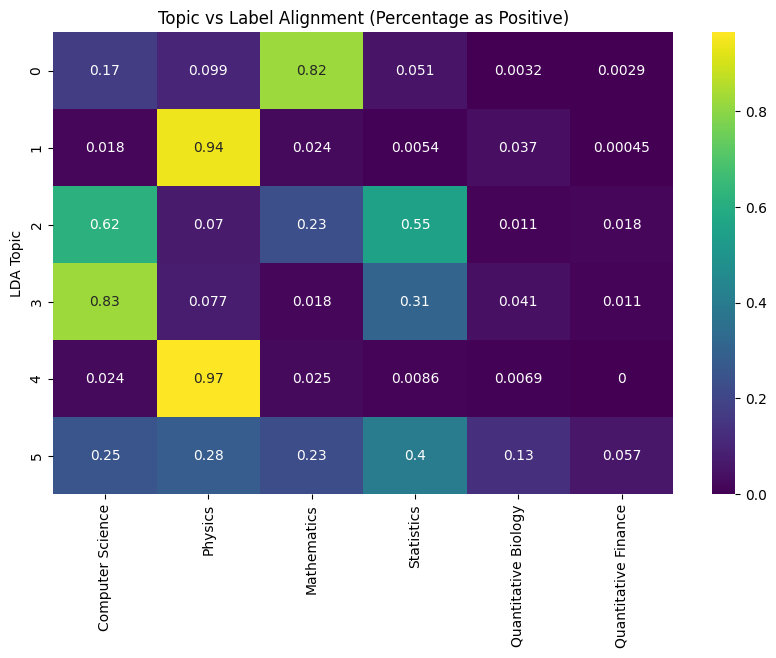

In [73]:
import seaborn as sns
import matplotlib.pyplot

plt.figure(figsize=(10,6))
sns.heatmap(summary, annot=True, cmap="viridis")
plt.title("Topic vs Label Alignment (Percentage as Positive)")
plt.ylabel("LDA Topic")
plt.show()

### LDA Topic Interpretation

- Topic 0  Mathematics
| Mathematics = .82

- Topic 1 Physics - Physics = .94 while everything else is near zero

- Topic 2 CS = .62, Statistics = .55, and Math = .23 | ML and DS vocabulary

- Topic 3 CS = .83, and Statistics = .31 | Algorithms/ML/applied stats

- Topic 4 Physics =.97  Second pure physics cluster

- Topic 5 Statistics = .4, Physics = .28, CS = .25, Math = .23, Quant Bio = .13 | Mixed interdisciplinary cluster

Unsupervised LDA successfully recovered dominant disciplinary clusters (Physics, Mathematics), but failed to isolate minority fields such as Quantitative Finance and Quantitative Biology due to class sparsity.  Because of data sparsity and large class imbalance, LDA is not an optimal classifier.  Rare classes require discriminative modeling




### Classical Baseline Modeling

#### TF-IDF + OneVsRest Logistic Regression

Because of heavy class imbalance, we will use `class_weight = "balanced"`, Macro F1 evaluation and per-class precision/recall

In [74]:
from sklearn.model_selection import train_test_split

target_cols = [
    "Computer Science",
    "Physics",
    "Mathematics",
    "Statistics",
    "Quantitative Biology",
    "Quantitative Finance"
]

X = df["cleaned_text"]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    min_df=5,
    max_df=.9
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    )
)

model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000))

In [77]:
y_pred = model.predict(X_test_tfidf)
#

In [78]:
from sklearn.metrics import f1_score, classification_report

print("Micro F1 Score:", f1_score(y_test, y_pred, average="micro"))
print("Macro F1 Score:", f1_score(y_test, y_pred, average="macro"))

print(classification_report(y_test, y_pred, target_names=target_cols))

Micro F1 Score: 0.8225432495095416
Macro F1 Score: 0.7656686560970227
                      precision    recall  f1-score   support

    Computer Science       0.80      0.88      0.84      1692
             Physics       0.86      0.88      0.87      1226
         Mathematics       0.78      0.86      0.82      1150
          Statistics       0.73      0.87      0.79      1069
Quantitative Biology       0.44      0.71      0.55       122
Quantitative Finance       0.67      0.80      0.73        45

           micro avg       0.78      0.87      0.82      5304
           macro avg       0.71      0.83      0.77      5304
        weighted avg       0.79      0.87      0.82      5304
         samples avg       0.82      0.89      0.84      5304



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Probability-Based Predictions

Threshold Tuning

In [79]:
import numpy as np
from sklearn.metrics import f1_score

y_probs = model.predict_proba(X_test_tfidf)
best_thresholds = {}
best_f1s = {}
for i, label in enumerate(target_cols):
  best_f1 = 0
  best_thresh = 0.5
  for thresh in np.linspace(.1,.9,50):
    preds = (y_probs[:, i] >= thresh).astype(int)
    f1 = f1_score(y_test.iloc[:,i], preds)

    if f1 > best_f1:
      best_f1 = f1
      best_thresh = thresh

  best_thresholds[label] = best_thresh
  best_f1s[label] = best_f1

print("Best F1 Scores:", best_f1s)
best_thresholds


Best F1 Scores: {'Computer Science': 0.8495478213209099, 'Physics': 0.8777589134125636, 'Mathematics': 0.8167843788948899, 'Statistics': 0.7956081081081081, 'Quantitative Biology': 0.5724137931034483, 'Quantitative Finance': 0.7692307692307693}


{'Computer Science': np.float64(0.44285714285714284),
 'Physics': np.float64(0.6224489795918368),
 'Mathematics': np.float64(0.5081632653061224),
 'Statistics': np.float64(0.49183673469387756),
 'Quantitative Biology': np.float64(0.5571428571428572),
 'Quantitative Finance': np.float64(0.573469387755102)}

#### Threshold Tuning Results
##### New Best F1 Scores

| Label                | Before | After     | Δ  |
| -------------------- | ------ | --------- | -- |
| Computer Science     | 0.84   | **0.849** | ↑  |
| Physics              | 0.87   | **0.879** | ↑  |
| Mathematics          | 0.82   | **0.817** | ≈  |
| Statistics           | 0.79   | **0.796** | ↑  |
| Quantitative Biology | 0.54   | **0.579** | 🔼 |
| Quantitative Finance | 0.73   | **0.769** | 🔼 |


There is meaningful gains in the imbalanced classes
Quantitative Biology and Quantitative Finance.

Quantitative Finance gains were strong for a class with only
~ 45 test samples.

Set your google colab runtime to use GPU, a must for deep learning!

In [33]:
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text,label_count,lda_topic
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...,reconstruct subject specific effect maps predi...,1,3
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...,rotation invariance neural network rotation in...,1,3
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...,1,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...,1,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...,2,2


### Deep Learning with sciBERT

Let's install dependencies

In [35]:
!pip -q install transformers datasets accelerate scikit-learn

In [36]:
df["text"] = (df["TITLE"].fillna("")+df["ABSTRACT"].fillna("")).str.strip()

target_cols = [
    "Computer Science",
    "Physics",
    "Mathematics",
    "Statistics",
    "Quantitative Biology",
    "Quantitative Finance"
]

for c in target_cols:
  df[c] = df[c].astype(int)

df[["text"] + target_cols].head()

,text,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps P...,1,0,0,0,0,0
1,Rotation Invariance Neural Network Rotation i...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,1,0,0,1,0,0


Train/Test Split

In [37]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df[["text"]+ target_cols],
    test_size=0.2,
    random_state=42
)

Create HF Datasets + tokenize

In [39]:
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize_batch(batch):
  enc = tokenizer(
      batch["text"],
      truncation=True,
      padding="max_length",
      max_length=256,
  )

  #multi-label targets -> a float vector for BCEWithLogits
  enc["labels"] = [[float(batch[c][i]) for c in target_cols] for i in range(len(batch["text"]))]

  return enc

train_tok = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"] + target_cols)
test_tok = test_ds.map(tokenize_batch, batched=True, remove_columns=["text"] + target_cols)
#
train_tok.set_format("torch")
test_tok.set_format("torch")

Map:   0%|          | 0/16777 [00:00<?, ? examples/s]

Map:   0%|          | 0/4195 [00:00<?, ? examples/s]

Define model (multi-label)

In [40]:
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    num_labels=len(target_cols),
    problem_type="multi_label_classification"
)

torch.cuda.is_available()

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: allenai/scibert_scivocab_uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were ne

True

Metrics (micro/macro F1) with a default threshold

In [46]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  prob = 1 / (1 + np.exp(-logits)) #sigmoid
  preds = (prob >= .5).astype(int)
  labels = labels.astype(int)

  return {
      "f1_micro": f1_score(labels, preds, average="micro",zero_division=0),
      "f1_macro": f1_score(labels, preds, average="macro",zero_division=0),
  }

Train (Colab GPU-friendly settings)

In [47]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

args = TrainingArguments(
    output_dir="scibert_multilabel",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_strategy="epoch",
    greater_is_better=True,
    fp16=True,
    report_to="none",
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    processing_class=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.116891,0.198551,0.824957,0.723116
2,0.100642,0.186419,0.838220,0.781645
3,0.066681,0.207241,0.838517,0.776972


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=6294, training_loss=0.0970042901149734, metrics={'train_runtime': 1257.9382, 'train_samples_per_second': 40.011, 'train_steps_per_second': 5.003, 'total_flos': 6621559064349696.0, 'train_loss': 0.0970042901149734, 'epoch': 3.0})

In [48]:
trainer.evaluate()

{'eval_loss': 0.18644531071186066,
 'eval_f1_micro': 0.8380609050374728,
 'eval_f1_macro': 0.7815447858484877,
 'eval_runtime': 19.8791,
 'eval_samples_per_second': 211.026,
 'eval_steps_per_second': 13.23,
 'epoch': 3.0}

Per-class report (precision/recall/F1 by label)

In [49]:
from sklearn.metrics import classification_report

pred = trainer.predict(test_tok)
logits = pred.predictions
labels = pred.label_ids.astype(int)

prob = 1 / (1 + np.exp(-logits)) #sigmoid
y_pred = (prob >= 0.5).astype(int)

print(classification_report(labels, y_pred, target_names=target_cols, zero_division=0))

                      precision    recall  f1-score   support

    Computer Science       0.83      0.87      0.85      1692
             Physics       0.91      0.89      0.90      1226
         Mathematics       0.90      0.75      0.82      1150
          Statistics       0.78      0.83      0.80      1069
Quantitative Biology       0.58      0.56      0.57       122
Quantitative Finance       0.86      0.67      0.75        45

           micro avg       0.84      0.83      0.84      5304
           macro avg       0.81      0.76      0.78      5304
        weighted avg       0.85      0.83      0.84      5304
         samples avg       0.87      0.87      0.85      5304



LDA captured dominant disciplinary clusters but failed on minority fields. A TF-IDF logistic baseline achieved 0.76 macro F1. SciBERT improved macro F1 to 0.78, with notable gains in Physics and Mathematics. However, rare-class performance remained constrained by label imbalance.

Threshold Tuning

In [51]:
best_thresholds = {}
best_f1s = {}

for i, label in enumerate(target_cols):
  best_f1 = -1
  best_t = 0.5
  for t in np.linspace(.1,.9,81):
    preds_i = (prob[:,i] >= t).astype(int)
    f1 = f1_score(labels[:,i], preds_i, zero_division=0)
    if f1 > best_f1:
      best_f1 = f1
      best_t = t
  best_thresholds[label] = best_t
  best_f1s[label] = best_f1

print("Best F1 Scores:", best_f1s)

Best F1 Scores: {'Computer Science': 0.8574622694242594, 'Physics': 0.8982912937347437, 'Mathematics': 0.8416055243849806, 'Statistics': 0.8075240594925635, 'Quantitative Biology': 0.6254545454545455, 'Quantitative Finance': 0.8}


In [52]:
y_pred_tuned = np.zeros_like(y_pred)
for i, label in enumerate(target_cols):
  y_pred_tuned[:,i] = (prob[:,i] >= best_thresholds[label]).astype(int)

print("Micro F1 Score:", f1_score(labels, y_pred_tuned, average="micro", zero_division=0))
print("Macro F1 Score:", f1_score(labels, y_pred_tuned, average="macro", zero_division=0))

print(classification_report(labels, y_pred_tuned, target_names=target_cols, zero_division=0))

Micro F1 Score: 0.8465800708511219
Macro F1 Score: 0.8050562820818489
                      precision    recall  f1-score   support

    Computer Science       0.81      0.91      0.86      1692
             Physics       0.90      0.90      0.90      1226
         Mathematics       0.84      0.85      0.84      1150
          Statistics       0.76      0.86      0.81      1069
Quantitative Biology       0.56      0.70      0.63       122
Quantitative Finance       0.76      0.84      0.80        45

           micro avg       0.82      0.88      0.85      5304
           macro avg       0.77      0.84      0.81      5304
        weighted avg       0.82      0.88      0.85      5304
         samples avg       0.86      0.90      0.86      5304



### Summary

####  Machine Learning vs Deep Learning Model Comparison Summary
##### Overall Performance

| Model                        | Threshold Strategy  | Micro F1   | Macro F1   | Notes                                    |
| ---------------------------- | ------------------- | ---------- | ---------- | ---------------------------------------- |
| TF-IDF + Logistic Regression | Default (0.5)       | ~0.82      | ~0.76      | Strong baseline, minority classes weaker |
| TF-IDF + Logistic Regression | Tuned per label     | ~0.83      | ~0.79      | Threshold tuning improves macro F1       |
| SciBERT                      | Default (0.5)       | ~0.84      | ~0.78      | Better contextual representation         |
| **SciBERT**                  | **Tuned per label** | **0.8466** | **0.8051** | Best overall + strongest minority gains  |

---
#### Per-Class F1 Comparison (Best Logistic vs Best SciBERT)

| Class                | Logistic (Tuned) | SciBERT (Tuned) | Improvement |
| -------------------- | ---------------- | --------------- | ----------- |
| Computer Science     | ~0.85            | **0.86**        | +           |
| Physics              | ~0.88            | **0.90**        | +           |
| Mathematics          | ~0.82            | **0.84**        | +           |
| Statistics           | ~0.80            | **0.81**        | +           |
| Quantitative Biology | 0.58             | **0.63**        | 🔼 Major    |
| Quantitative Finance | 0.77             | **0.80**        | 🔼 Major    |



### Conclusions

This study used multi-label classification of scientific papers across six academic disciplines using three modeling approaches: unsupervised topic modeling (LDA), classical machine learning (TF-IDF + Logistic Regression), and transformer-based fine-tuning (SciBERT).

#### Unsupervised Topi Modeling Revealed Structure - But Not Minority Classes

LDA successfully identified dominant disciplinary clusters, particularly in Physics and Mathematics followed by Computer Science and Statistics.  However, due to data sparsity Quantitative Biology and Quantitative Finance were harder isolate.

This shows for classification purposes:
- Unsupervised models capture broad semantic structure
- Rare classes do not form stable latent topics when sparsely represented
- Topic modeling in this manner is useful for exploration, but less useful for discriminative classfications.

#### Classical Machine Learning Provided a Strong Baseline

A TF-IDF + One-vs-Rest Logistic Regression model achieved:
- ~.76-.79 Macro F1 (with threshold tuning)

We see a familiar pattern with the baseline performing well on majority classes but stugggling on the more severly imbalanced minority classes.

Big takeaway:

Proper feature engineering and threshold calibration are extremely useful even without deep learning.

#### SciBERT Improved Representation Quality

Fine-tuning SciBERT yielded:
- .805 Macro F1
- .846 Micro F1

We also saw performance gains in minority classes:
- Quantitative Biology improved from ~0.54 -> 0.63 F1
- Quantitative Finance improved from ~0.73 -> 0.80 F1

This indicates that contextual embeddings better capture domain-specific vocabulary in scientific writing.  

#### Class Imbalance Was the Primary Bottleneck

Across all models, the most significant limitation was not model capacity, but sparsity of minority class representation, and vocabulary overlap across disciplines.  Thus, data distribution constraints factor heavily even if architectual sophistication means to improve results.

#### Threshold Calibration Was Critical

Per-label probability threshold ttuning significantly improved Macro F1 across both classical and transformer models.

#### Final Conclusions
LDA is effective for exploratory structure discovery but insufficient for classification for this project related work.  Classic models are important and competitive baselines with a stronger degree of model interpretability (e.g., logistic regression).  Domain-specific transformers (SciBERT) prrovide measurable gains.  Minority class performance depends heavily on imbalance mitigation and calibration.  Model selection must be guided by evaluation strategy, not just complexity.  

## References

Blesson Densil. (n.d.). Topic Modeling for Research Articles [Dataset]. Kaggle.
https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles